In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

Base

sqlalchemy.ext.automap.Base

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

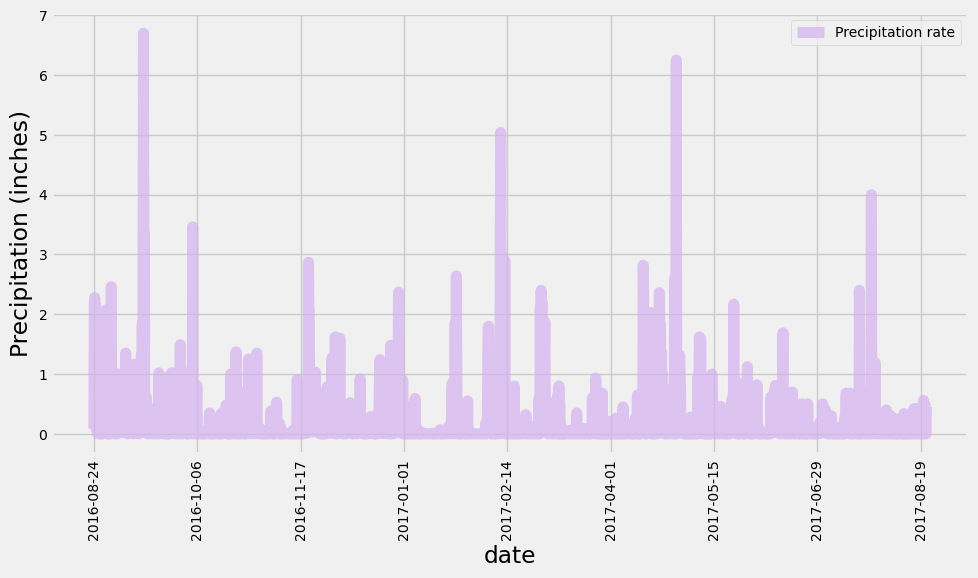

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
year_back = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_rate = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_back).\
    order_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_rate)
prcp_df = prcp_df.rename(columns={"prcp": "Precipitation rate"})

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='date')
prcp_df = prcp_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(x="date", y="Precipitation rate", color ='#d6b2f0',
                  figsize=(10,6), linewidth=8, alpha = 0.7)
plt.xlabel('date')
plt.ylabel('Precipitation (inches)')
plt.xticks(fontsize=10, rotation=90)  
plt.yticks(fontsize=10)  
plt.legend(['Precipitation rate'], fontsize=10)  
plt.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.show()

# Close the session
session.close()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation rate
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.station.distinct())).scalar()
num_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_join=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = station_join[0][0]
temp_stats = session.query(func.min(Measurement.tobs), 
                           func.max(Measurement.tobs), 
                           func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station_id).first()

temp_stats

(54.0, 85.0, 71.66378066378067)

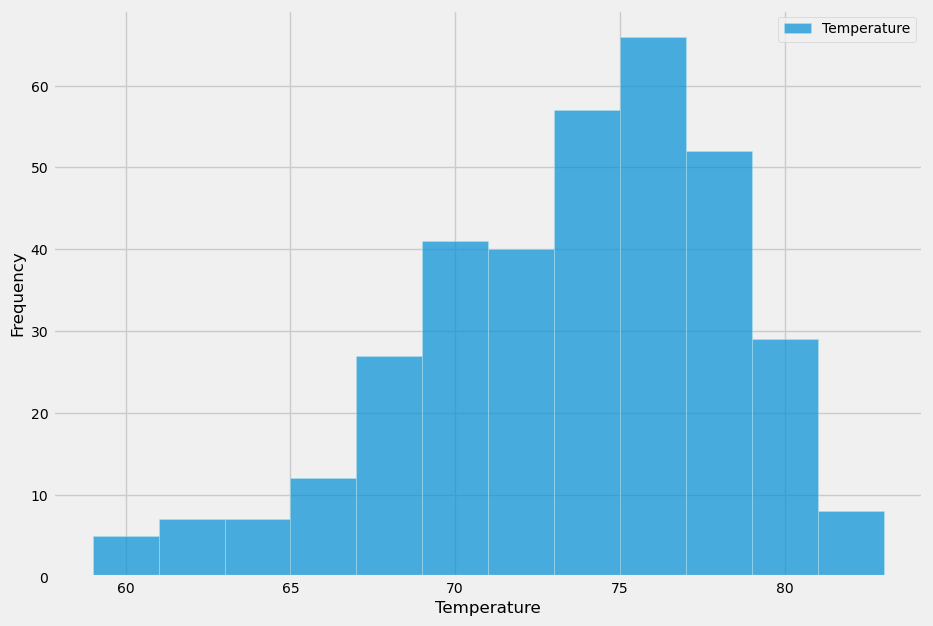

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in the dataset
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
year_back = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query the most active station id
active_station_id = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()[0]

# Query the last 12 months of temperature observation data for this station
query_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station_id, Measurement.date >= year_back).all()

# Create DataFrame for histogram
temp_df = pd.DataFrame(query_temp, columns=['temperature'])

# Plot histogram
plt.figure(figsize=(10, 7))
plt.hist(temp_df['temperature'], bins=12, edgecolor='#b2e4f0', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)  
plt.legend(['Temperature'], fontsize=10)  
plt.tight_layout
plt.show()

# Close Session

In [16]:
# Close Session
session.close()